# Linear Regression, Confidence Intervals, and Standard Errors

[Resource](https://harvard-iacs.github.io/2018-CS109A/lectures/lecture-5/)

# Predictor Types and Feature Selection

[Resource](https://harvard-iacs.github.io/2018-CS109A/sections/section-3/solutions/)

For this section, our goal is to discuss the complexities around different types of data features and thinking carefully about how different data types and collinearity issues can affect our models, whether our true goal is inference or prediction.

For this section, we'll use the following packages:

In [40]:
# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)


# Other helpful functions
import itertools
import warnings
warnings.filterwarnings("ignore")

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)

# Extending Linear Regression by Transforming Predictors

Linear regression works great when our features are all continuous and all linearly affect the output. But often real data have more interesting characteristics. Here, we'll look at how we can extend linear regression to handle:
* Categorical predictors
* Interactions between predictors, which let us model how one variable changes the effect of another.

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data.

In [41]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [42]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [43]:
# Drop missing data (is this a good idea?)
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 1 to 889
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     182 non-null    int64   
 1   pclass       182 non-null    int64   
 2   sex          182 non-null    object  
 3   age          182 non-null    float64 
 4   sibsp        182 non-null    int64   
 5   parch        182 non-null    int64   
 6   fare         182 non-null    float64 
 7   embarked     182 non-null    object  
 8   class        182 non-null    category
 9   who          182 non-null    object  
 10  adult_male   182 non-null    bool    
 11  deck         182 non-null    category
 12  embark_town  182 non-null    object  
 13  alive        182 non-null    object  
 14  alone        182 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 18.2+ KB


Let's explore this data. Most people look at differences in survival, which is important but requires knowing how to deal with categorical responses, which we'll learn how to do next lesson. For this lesson, let's see if there are systematic differences in what fare people paid.

First, let's look at the distribution of fares.

In [44]:
print(titanic.fare.describe())

count    182.000000
mean      78.919735
std       76.490774
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64


<Axes: xlabel='fare'>

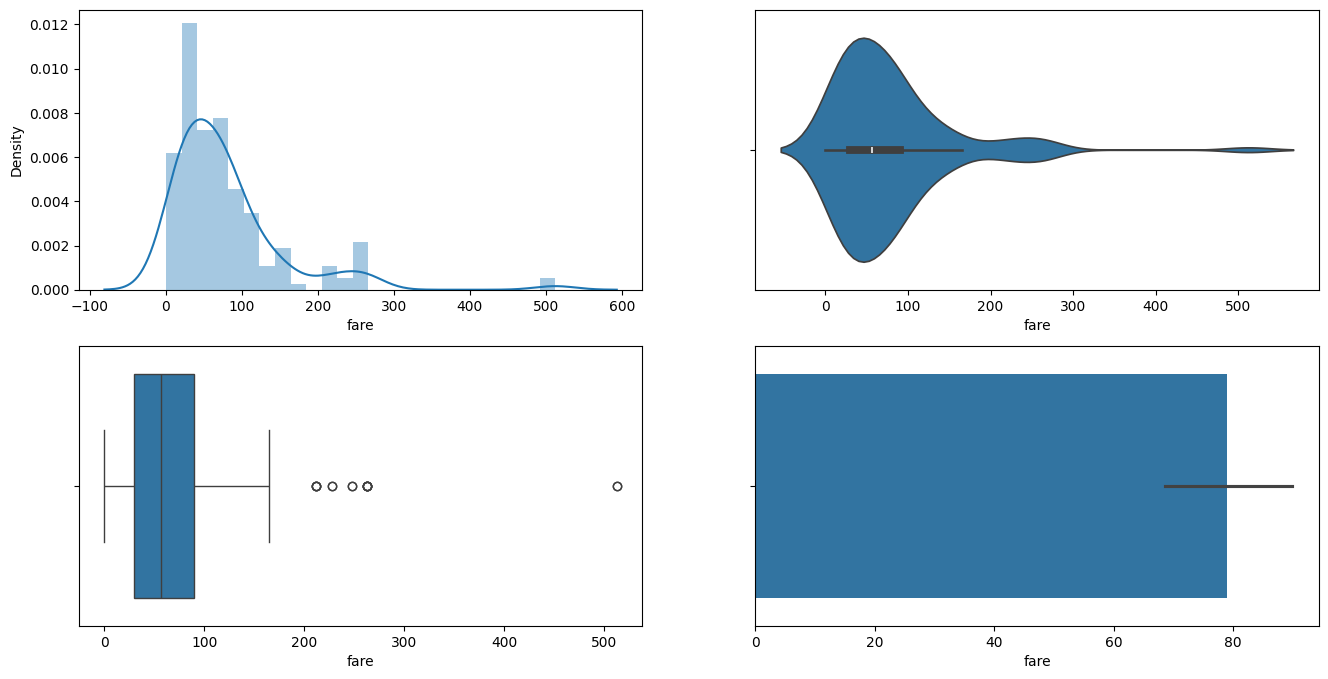

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
sns.distplot(titanic.fare, ax=axes[0,0])
sns.violinplot(x="fare", data=titanic, ax=axes[0,1])
sns.boxplot(x="fare", data=titanic, ax=axes[1,0])
sns.barplot(x="fare", data=titanic, ax=axes[1,1])

What do we learn from each visualization? Which is most helpful?

What can we say about the fares that passengers paid?\

A good visualization of the distribution of a variable will enable us to answer three kinds of questions:
* What values are typical? (mean, median, mode)
* What is the typical spread around those central values? (variance/stdev, skewness)
* What are unusual or exceptional values? (outliers)

The barplot clearly shows the mean and stdev, but that's about it. The other visualizations give complimentary info, e.g. the boxplot shows outliers clearly, but the histogram most clearly suggests that there might be secondary modes in addition to the primary mode.

Overall, we can see that most passengers paid below $50, but there are many outliers. If we were carefully analyzing the data, we might consider removing some outliers entirely and transforming the remaining data to make its distribution more normal. But for now we'll just use the data as-is.

## Exploring predictors

Cabin class is probably going to matter for fare, but we might wonder if age and gender also matter. Let's explore them.

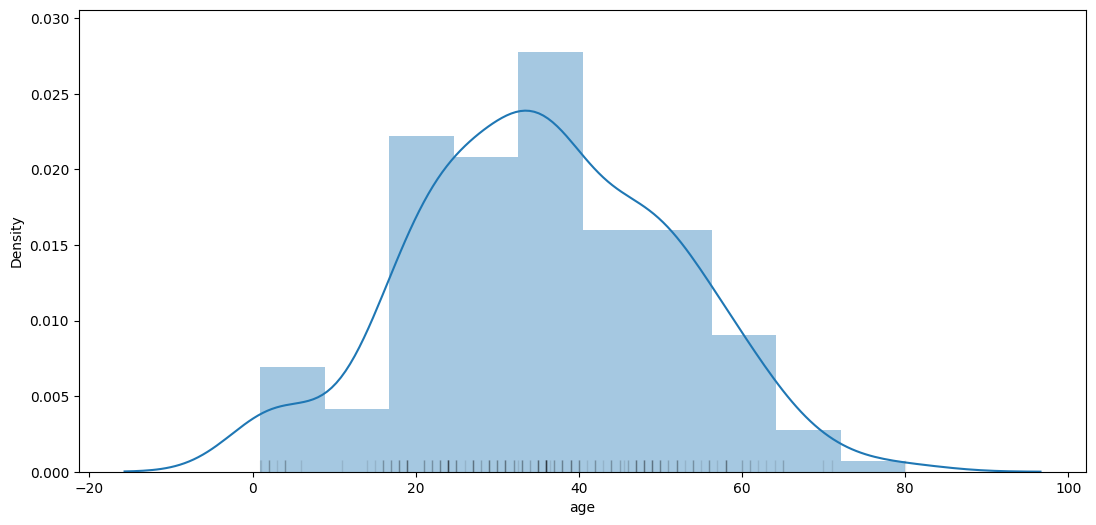

In [46]:
sns.distplot(titanic.age, rug=True, rug_kws={'alpha': .1, 'color': 'k'});

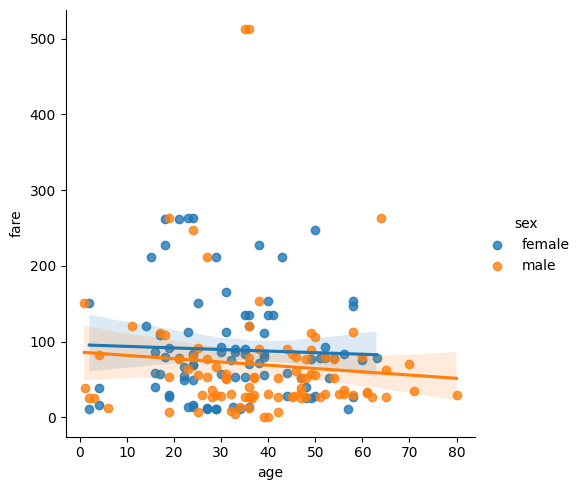

In [47]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic);

My version of Seaborn doesn't accept `size` as an argument for `lmplot`. Moreover, the professor's plot shows a positive relationship rather than the slightly negative one I'm seeing here. Either way, their main point is that males and females experience a slightly different slope in relation to fare. So we'll keep this in mind regardless.

How about sex and class?

In [48]:
print(titanic.sex.value_counts())

sex
male      94
female    88
Name: count, dtype: int64


And after seeing this, it seems like I might be working with a different data set altogether.

Let's see if the original data shows the same male and female counts as the professor's:

In [49]:
titanic2 = sns.load_dataset("titanic")
print(titanic2.sex.value_counts())

sex
male      577
female    314
Name: count, dtype: int64


Nope. I guess I might be working with different data then. Oh well!

In [50]:
print(titanic.sex.value_counts())

sex
male      94
female    88
Name: count, dtype: int64


In [51]:
titanic["class"].value_counts()

class
First     157
Second     15
Third      10
Name: count, dtype: int64

Note that we can't write `titanic.class.value_counts()` above because `class` is reserved as a keyword in Python.

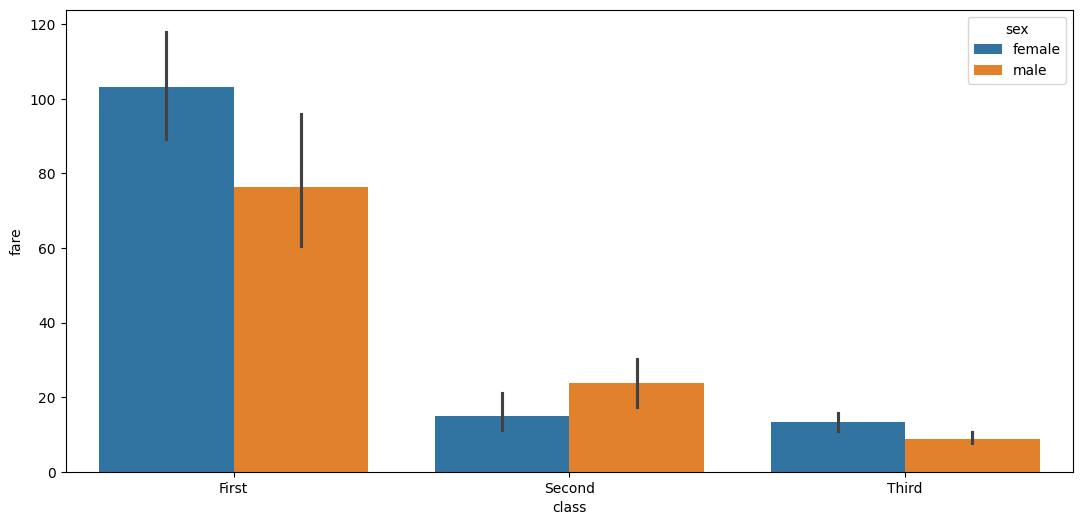

In [52]:
sns.barplot(x="class", hue="sex", y="fare", data=titanic);

Ugh, this is gonna be tricky with the different dataset I'm working with. So many tedious little obstacles in my way!

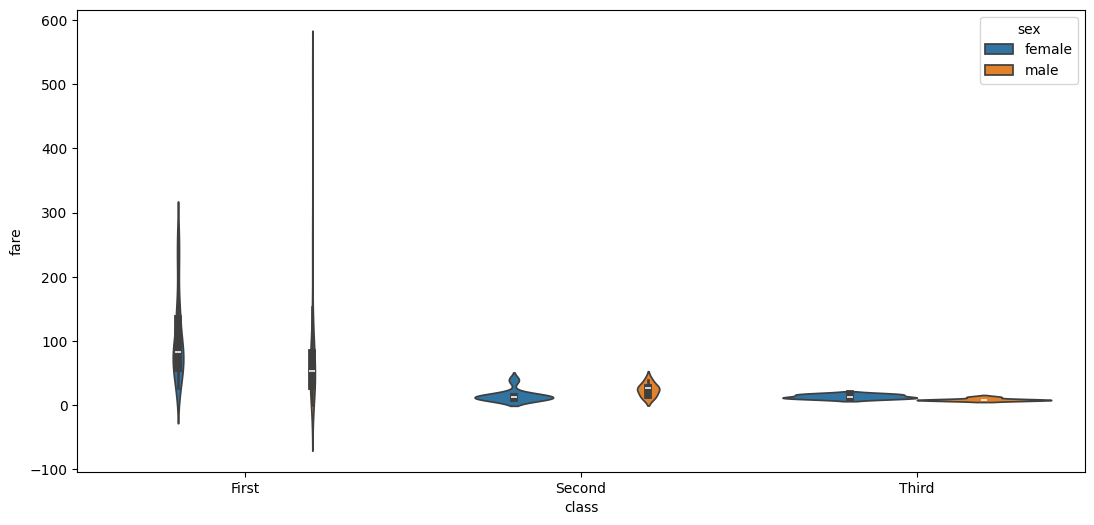

In [53]:
sns.violinplot(x="class", hue="sex", y="fare", data=titanic);

## Aside: can we replicate that violin plot without Seaborn?

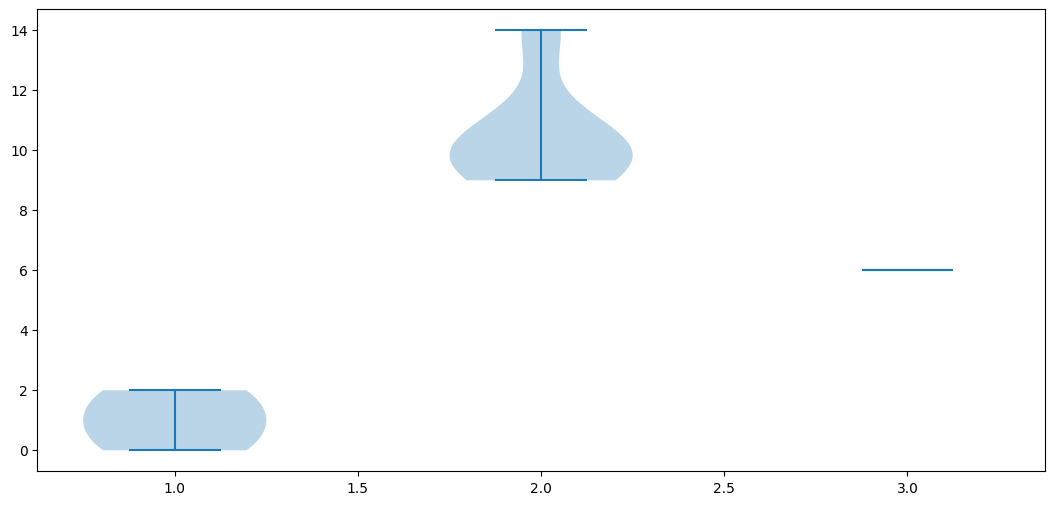

In [54]:
# plt.violinplot takes an array of data arrays, and plots each one as a separate violin.
# The data arrays don't have to be the same length.
# It returns Matplotlib objects corresponding to each of the pieces of the visualization.

plt.violinplot([
    [0,1,2], 
    [10, 14, 9, 10, 10, 10],
    [6]
]);

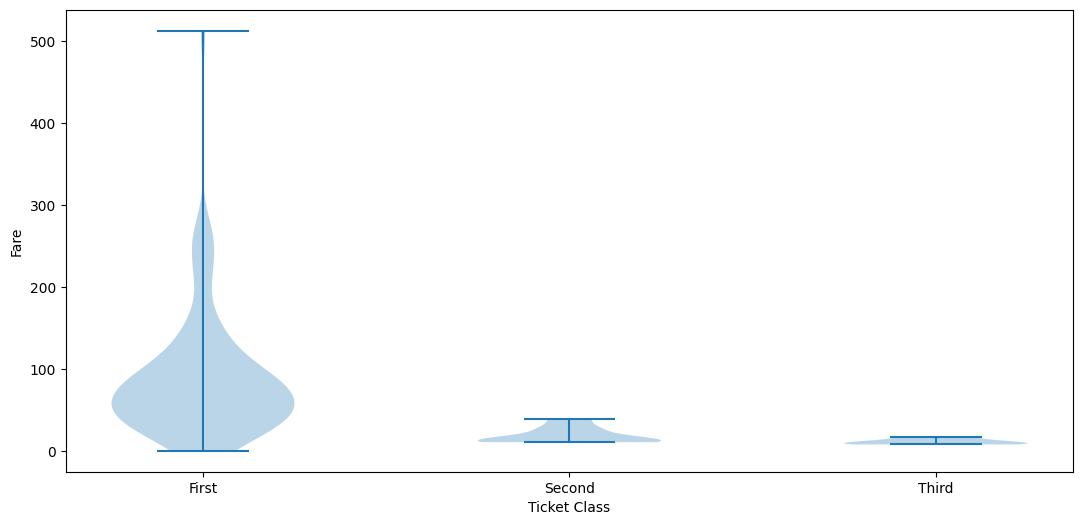

In [55]:
# We can use Pandas queries to make datasets for each class.
# We need to use `.values` to get plain Numpy arrays.
classes = 'First Second Third'.split()
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
])
plt.xticks([1,2,3], classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

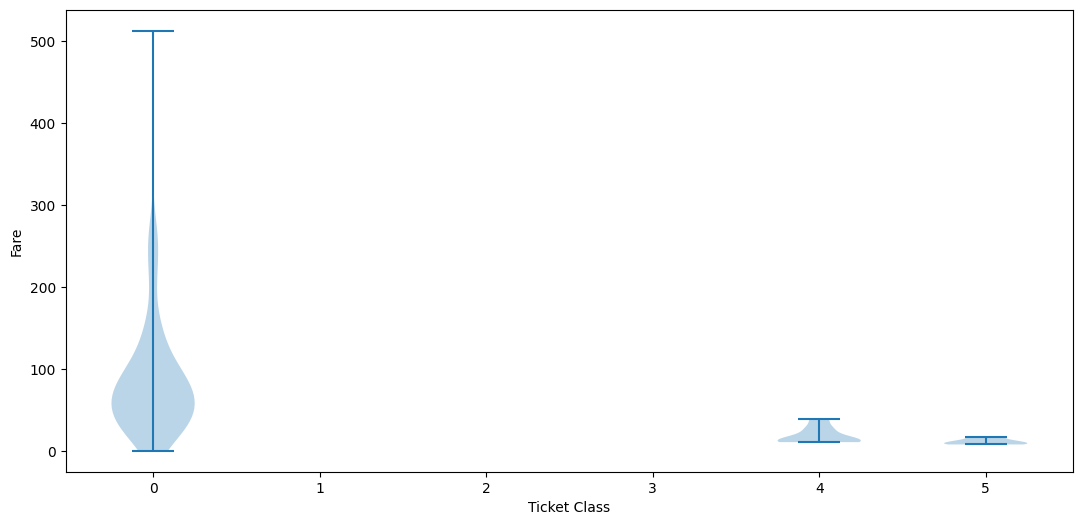

In [56]:
# It gets a little more tricky when we want to plot the two sexes side-by-side.
# Fortunately we can tell violinplot to place the violins at different positions.
position_array = [0, 4, 5] # just to show the effect of the position array.
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
], positions=position_array)
#plt.xticks(position_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

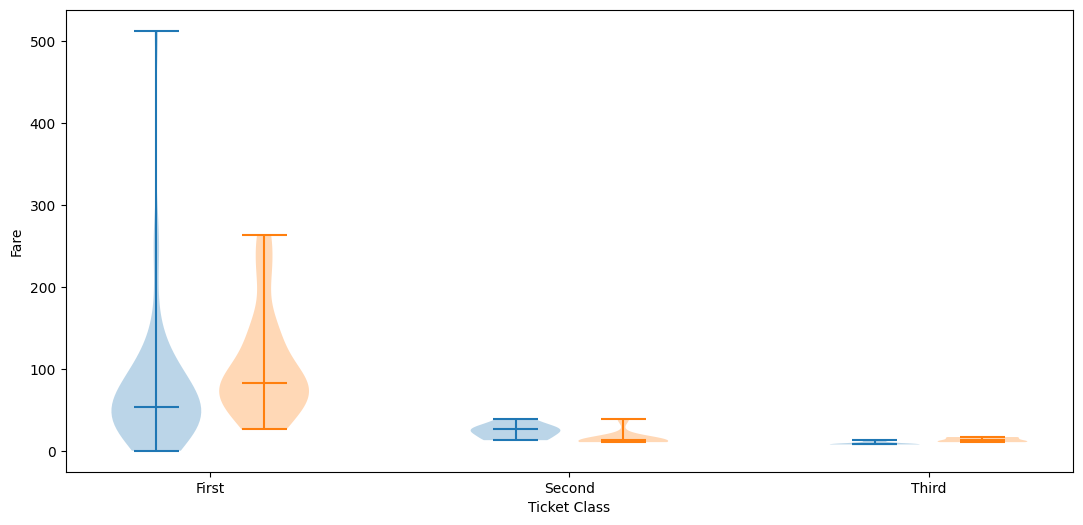

In [57]:
# We can use the position array to shift the male and female violins.

sexes = 'male female'.split()
positions_array = np.arange(len(classes)) # this will be [0, 1, 2]
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

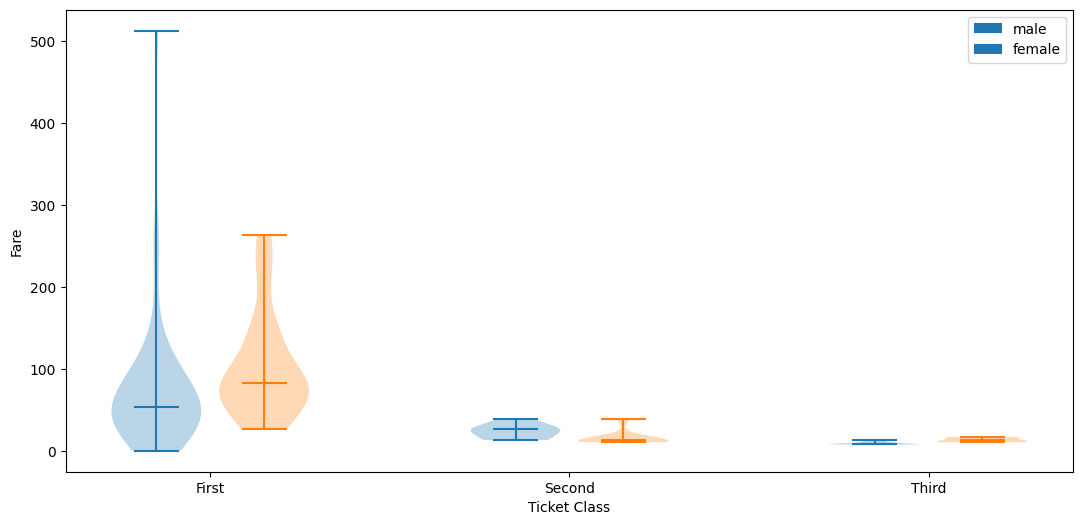

In [58]:
# But what about a legend? Unfortunately plt.violinplot doesn't support legends, so we
# have to do it by hand.
positions_array = np.arange(len(classes))
fake_handles = []
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
    fake_handles.append(mpatches.Patch())
plt.legend(fake_handles, sexes)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

## Back to regressions

So it looks like fare varies with class, age, and maybe gender, and the way that fare depends on class and age may be different for male vs. female.

Let's first do a simple linear regression on age.

In [59]:
model1 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic["age"])
).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.494
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.223
Time:                        15:15:03   Log-Likelihood:                -1046.4
No. Observations:                 182   AIC:                             2097.
Df Residuals:                     180   BIC:                             2103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.6951     14.094      6.719      0.0

According to the high p-value alone, there is not enough evidence here to reject the null hypothesis. Without considering outliers, it is highly unlikely that there is a relationship between fare and age. Again though, given that I'm working with different data the professor's results might differ. Let's plot and see what the regression looks like:

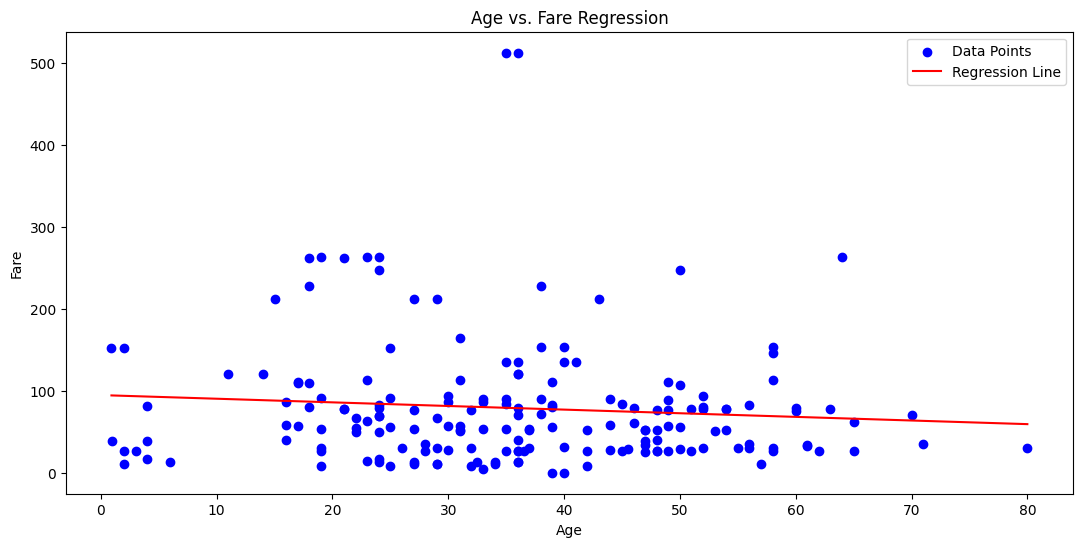

In [60]:
plt.scatter(titanic["age"], titanic["fare"], color="blue", label="Data Points")

x_range = np.linspace(titanic["age"].min(), titanic["age"].max(), 100)
y_pred = model1.params["const"] + model1.params["age"] * x_range # y = mx + b. Simple!

plt.plot(x_range, y_pred, color="red", label="Regression Line")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Age vs. Fare Regression")
plt.legend()
plt.show();

And let's see if Seaborn shows the same thing both for practice and clarity:

<Axes: xlabel='age', ylabel='fare'>

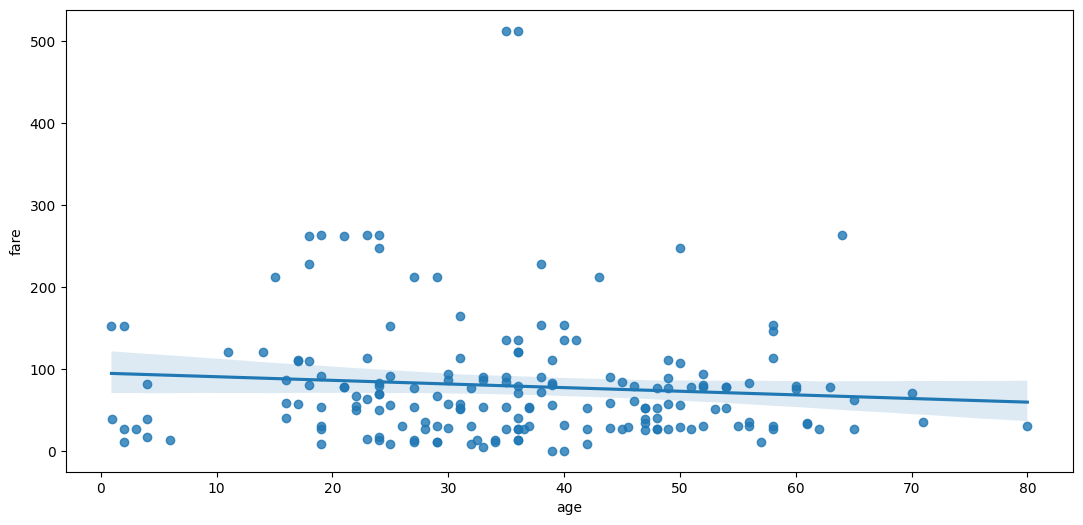

In [61]:
sns.regplot(data=titanic, x="age", y="fare")

Beautiful. Looks like things are working. These plots also indicate that the data is too spread out for this regression to be reliable. Even the more moderate outliers are affecting the regression. With little additional investigation (something we'll practice more in the actual application), it doesn't looks like age has a major affect on fare. However, this conclusion could be wrong. Anyway, let's continue.

## Handling categorical variables

Statistical packages generally distinguish between three types of variables:
* **Continuous** variables, like age and fare.
* **Nominal** variables, like gender and whether the person survived
* **Ordinal** variables like cabin class (fist, second, third)

How do we deal with gender or class? Obviously, they're categorical, so (as you know) we need to use dummy variables to encode them.

In [62]:
titanic_orig = titanic.copy()

Create a columnn `sex_male` that is 1 if the passenger is male, 0 otherwise:

In [63]:
titanic["sex_male"] = (titanic.sex == "male").astype(int)
titanic.sex_male.head()

1     0
3     0
6     1
10    0
11    0
Name: sex_male, dtype: int64

Do we need a `sex_female` column, or any others? No, because it's redundant: the only values for `sex` in this dataset are `male` and `female`, so if a passenger isn't male, we know they're female.

Now let's create columns for `class_`:

In [64]:
titanic["class_Second"] = (titanic["class"] == "Second").astype(int)
titanic["class_Third"] = (titanic["class"] == "Third").astype(int)

Now let's just do it the easy way with pandas:

In [65]:
titanic = pd.get_dummies(titanic_orig, columns=["sex", "class"], drop_first=True)
titanic.head()

,survived,pclass,age,sibsp,parch,fare,embarked,who,adult_male,deck,embark_town,alive,alone,sex_male,class_Second,class_Third
1,1,1,38.0,1,0,71.2833,C,woman,False,C,Cherbourg,yes,False,False,False,False
3,1,1,35.0,1,0,53.1000,S,woman,False,C,Southampton,yes,False,False,False,False
6,0,1,54.0,0,0,51.8625,S,man,True,E,Southampton,no,True,True,False,False
10,1,3,4.0,1,1,16.7000,S,child,False,G,Southampton,yes,False,False,False,True
11,1,1,58.0,0,0,26.5500,S,woman,False,C,Southampton,yes,True,False,False,False


**A quick explanation**

From Claude:

`drop_first=True` removes the first category from each dummy-encoded column to avoid multicollinearity.

When you convert a categorical variable to dummy variables, you get one column per category. But this creates redundancy - if you have columns for male/female, knowing someone isn't male tells you they're female. The information is duplicated.

For example, without `drop_first`:
- `sex_male` and `sex_female` (2 columns)
- `class_First`, `class_Second`, `class_Third` (3 columns)

With `drop_first=True`:
- `sex_male` only (1 column) - absence means female
- `class_Second`, `class_Third` only (2 columns) - absence of both means First class

This matters for regression models because having all categories creates perfect collinearity - the dropped category becomes your baseline/reference group that's encoded as all zeros.

Now let's fit a linear regression including the new sex and class variables:

In [ ]:
model2 = sm.OLS(
    titanic.fare.astype(float), # Had to add the float conversion here
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third']]).astype(float)
).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     8.749
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.82e-06
Time:                        15:21:20   Log-Likelihood:                -1030.7
No. Observations:                 182   AIC:                             2071.
Df Residuals:                     177   BIC:                             2087.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          133.8389     14.770      9.062   

**How do we interpret these results?**

Well... we're getting considerably better p-values, but obviously the r-squared value still tells us that much of the variance in the data is still not explained. The AIC and BIC values are about the same as well, indicating that 

In [78]:
print(f"Model 1 AIC: {model1.aic}")
print(f"Model 2 AIC: {model2.aic}")

Model 1 AIC: 2096.716372375223
Model 2 AIC: 2071.3852370001878


In [79]:
print(f"Model 1 BIC: {model1.bic}")
print(f"Model 2 BIC: {model2.bic}")

Model 1 BIC: 2103.1243857493764
Model 2 BIC: 2087.4052704355718


So model 2 performs better when comparing both AIC and BIC, indicating that model 2 achieves a better balance of fit and complexity (I need to review AIC and BIC again). What about the other params?

In [80]:
print(f"Model 1 f-statistic: {model1.fvalue}")
print(f"Model 2 f-statistic: {model2.fvalue}")

Model 1 f-statistic: 1.4940589006419203
Model 2 f-statistic: 8.748866994974955


Model 2 also improves the f-statistic as well, indicating (I think - again, I need to review these statistics) that **at least one** of the coefficients is useful in predicting fare.

Let's look at the R-squared value, then move on. Since I need to fully review these concepts, we won't dive too deep into them or place too much weight on my conclusions here.

In [81]:
print(f"Model 1 R-squared: {model1.rsquared}")
print(f"Model 2 R-squared: {model2.rsquared}")

Model 1 R-squared: 0.008231998940857022
Model 2 R-squared: 0.16507649108431832


It looks like (unsurprisingly) model 2 explains more of the variance in the data than model 1. Based on my limited (forgotten) knowledge, it seems like model 2 is pretty conclusively the better model. Let's move on!

# Interactions

You've done these before. They're simple! You're just adding another degree to the polynomial (I think that's the correct terminology, but either way I know I have the right idea). Let's get to it.

According to our beloved professor, it seemed like gender interacted with age and class.

Also, notice that the interaction term is included with the coefficients that were used to create it. Not sure if this is what you're always meant to do, but certainly worth noting.

In [85]:
titanic["sex_male_X_age"] = titanic["age"] * titanic["sex_male"]
model3 = sm.OLS(
    titanic.fare.astype(float),
    sm.add_constant(titanic[["age", "sex_male", "class_Second", "class_Third", "sex_male_X_age"]]).astype(float)
    ).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     7.012
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           5.32e-06
Time:                        15:44:21   Log-Likelihood:                -1030.6
No. Observations:                 182   AIC:                             2073.
Df Residuals:                     176   BIC:                             2092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            127.6015     19.900      6.

What has happened to the R-squared as we added more features? Does this mean that the model is better? (What id we kept adding more predictors and interaction terms? We'll explore this more later)

My initial reaction is that R-squared is just a small portion of interpreting a model. A higher R-squared indicates that a model explains more variance in the data, but adding more and more predictors could simply just beef up that R-squared value into redundancy. I'm pretty sure if you included all the predictors, you'd end up with an R-squared value of 1. Let's test that by adding all numeric columns (essentially just excluding the columns we didn't one-hot encode, since I don't feel like one-hot encoding everything) to the regression:

In [100]:
test_model = sm.OLS(
    titanic.fare.astype(float),
    sm.add_constant(titanic.drop(["fare", "who", "deck", "embark_town", "embarked", "alive"], axis=1).astype(float))
).fit()

test_model.rsquared

np.float64(0.33057587350457784)

So yea, as I'm pretty sure I've learned previously (man, I really gotta review), adding parameters is pretty much guaranteed to explain more of the variance in the model. We'll do the deep dive into that later.

# Model Selection via Exhaustive Search Selection

The dataset for this problem contains 10 simulated predictors and a response variable.

In [101]:
data = pd.read_csv("../data/dataset3.csv")
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.488866,0.488866,0.488866,0.078913,0.098292,0.144871,0.065302,0.250225,-0.392509,-0.501255,0.625915
1,0.146479,0.146479,0.146479,0.022562,0.088052,0.104879,0.082436,0.332836,-0.178366,-0.061798,0.058947
2,0.525450,0.525450,0.525450,-0.157520,-0.328685,-0.246146,-0.233882,0.054153,-0.010547,0.393186,-0.176577
3,0.351241,0.351241,0.351241,-0.062256,-0.096287,-0.033425,-0.088843,-0.475510,-0.066429,-0.249999,0.154168
4,-0.168068,-0.168068,-0.168068,-0.080250,-0.155529,-0.099511,-0.106430,-0.203144,0.194485,-0.037681,-0.288597


By visually inspecting the data set, do we find that some of the predictors are correlated amongst themselves?

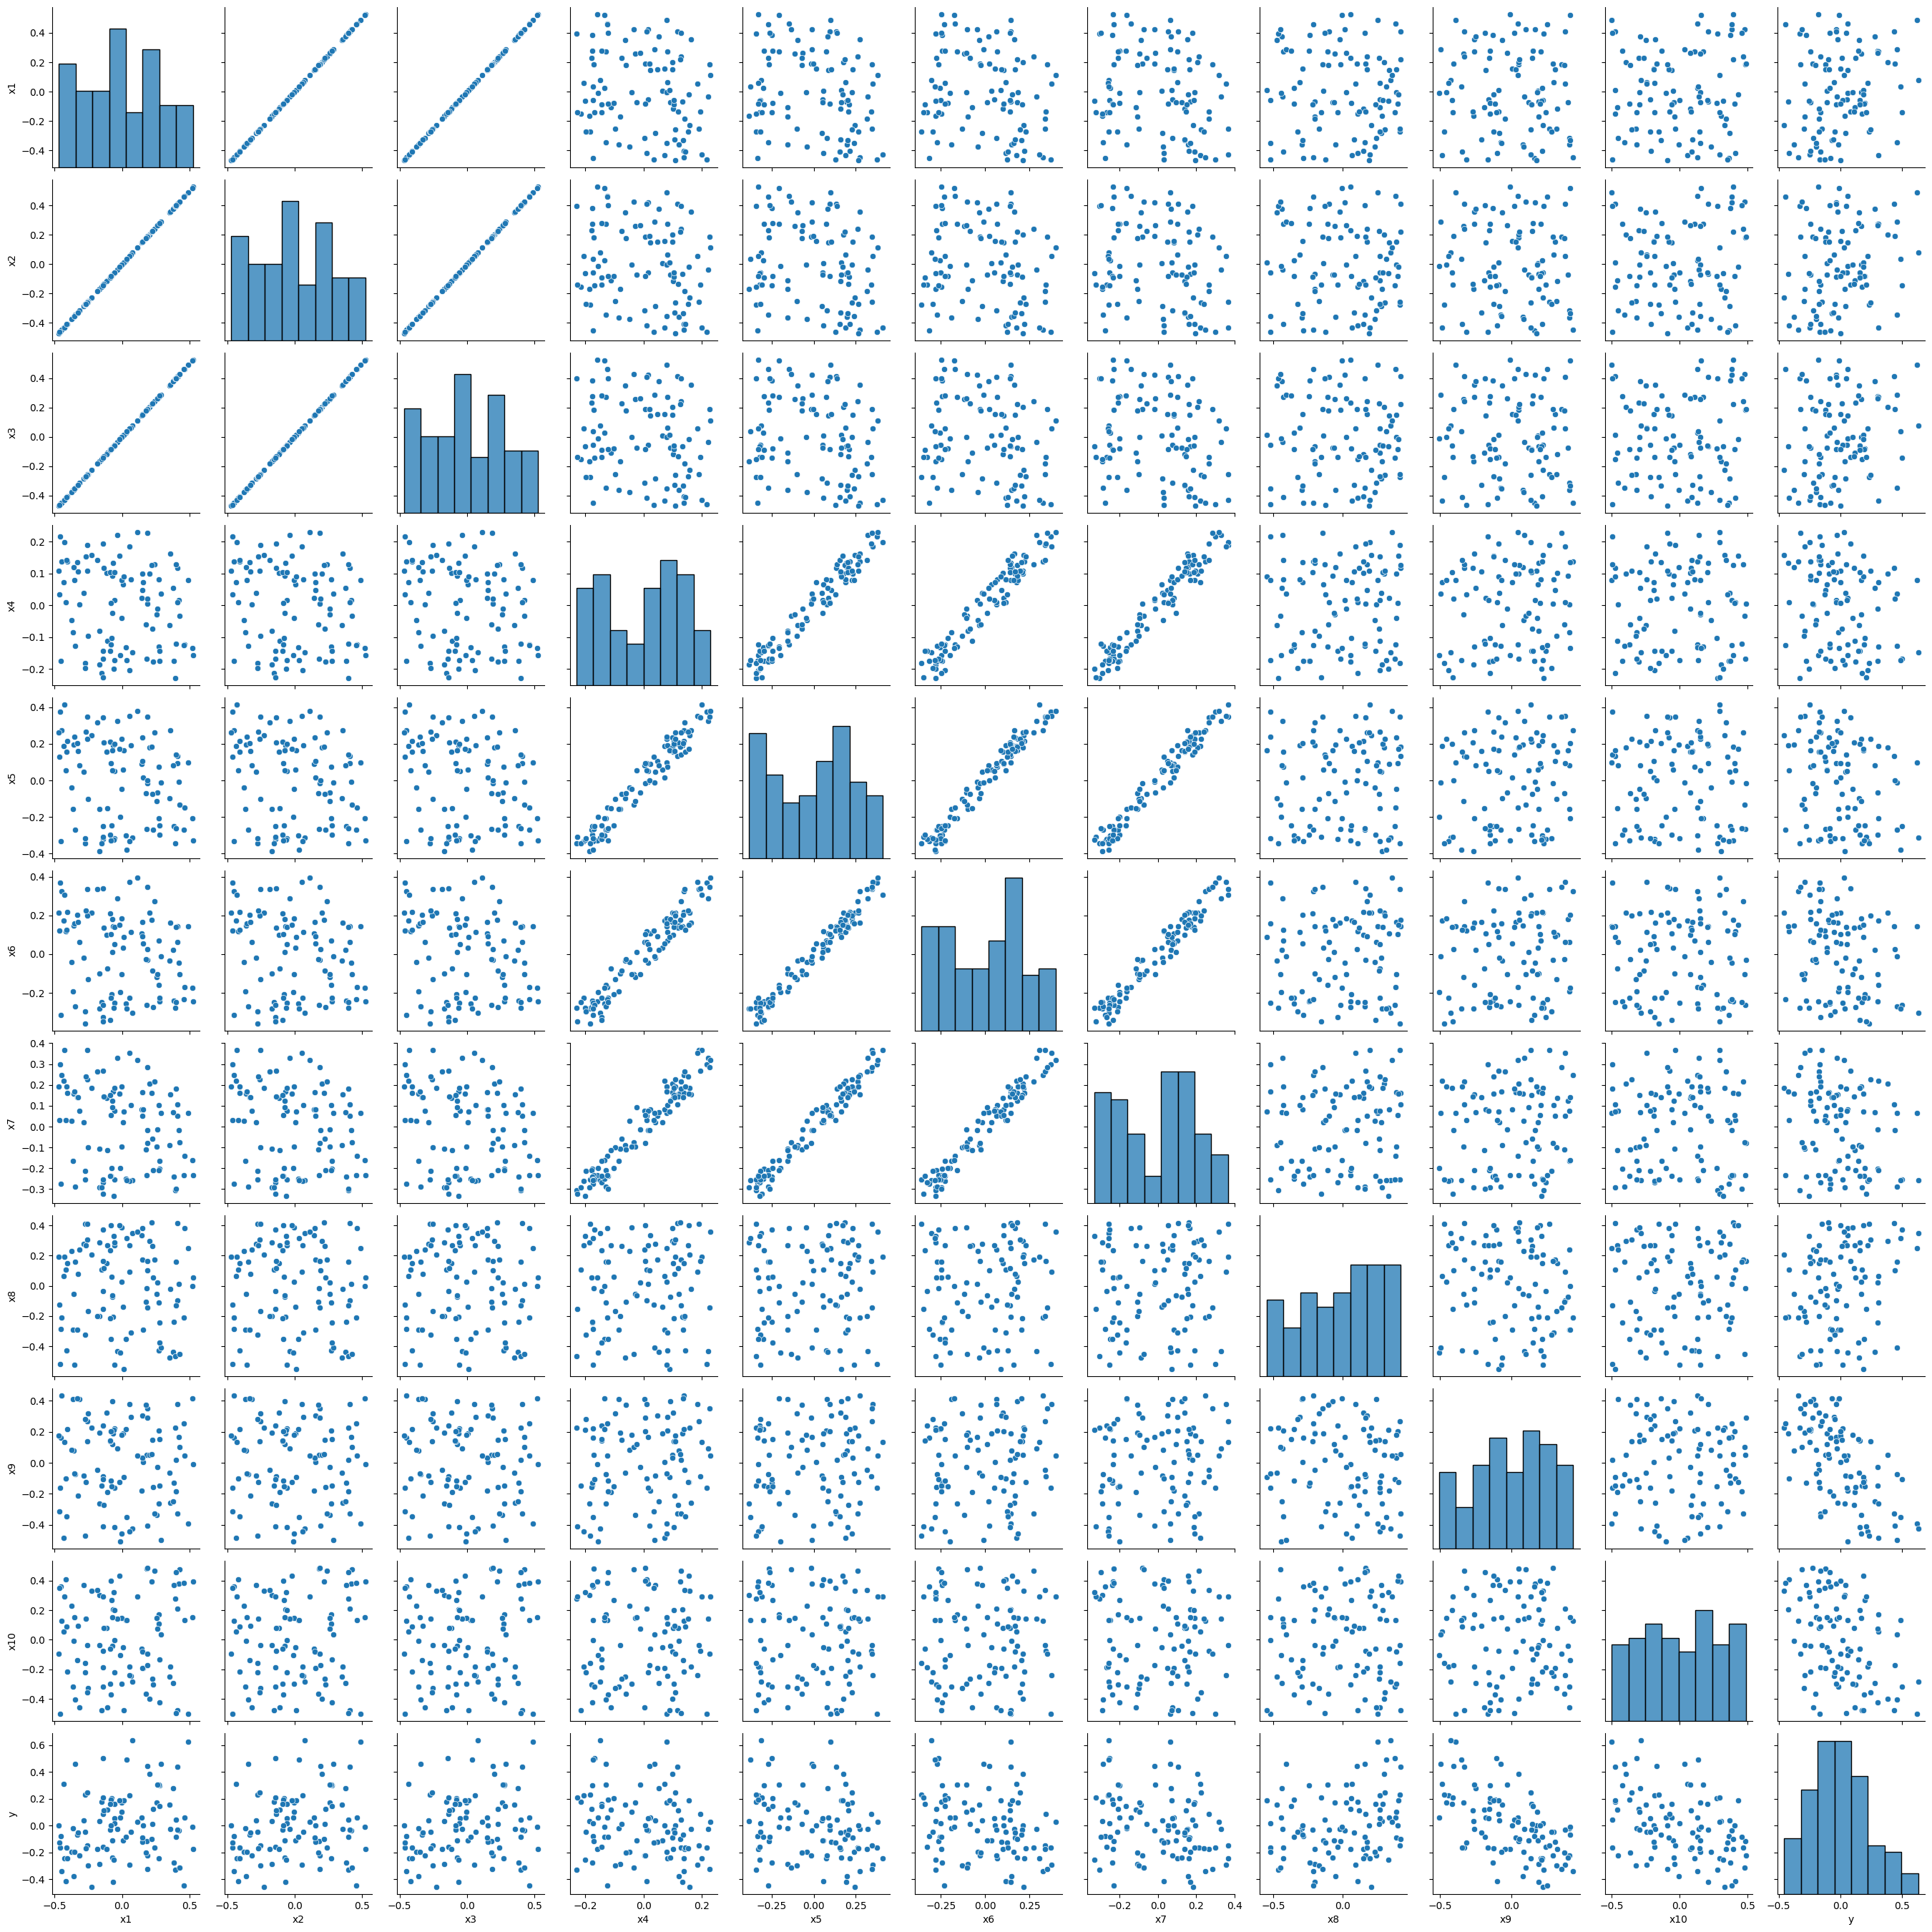

In [103]:
sns.pairplot(data);

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 show very high degrees of correlation.

In [105]:
print(data.corr())

           x1        x2        x3        x4        x5        x6        x7        x8        x9       x10         y
x1   1.000000  1.000000  1.000000 -0.189945 -0.232439 -0.215623 -0.228322 -0.047643 -0.061022  0.050977  0.195962
x2   1.000000  1.000000  1.000000 -0.189945 -0.232439 -0.215623 -0.228322 -0.047643 -0.061022  0.050977  0.195962
x3   1.000000  1.000000  1.000000 -0.189945 -0.232439 -0.215623 -0.228322 -0.047643 -0.061022  0.050977  0.195962
x4  -0.189945 -0.189945 -0.189945  1.000000  0.974279  0.964344  0.969540  0.058516  0.108294 -0.010416 -0.225856
x5  -0.232439 -0.232439 -0.232439  0.974279  1.000000  0.982785  0.982227  0.080342  0.126004 -0.012399 -0.257433
x6  -0.215623 -0.215623 -0.215623  0.964344  0.982785  1.000000  0.976308  0.079547  0.123368 -0.021029 -0.261228
x7  -0.228322 -0.228322 -0.228322  0.969540  0.982227  0.976308  1.000000  0.074004  0.112241 -0.022023 -0.235921
x8  -0.047643 -0.047643 -0.047643  0.058516  0.080342  0.079547  0.074004  1.000000 -0.1

Let us compute the coefficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map.

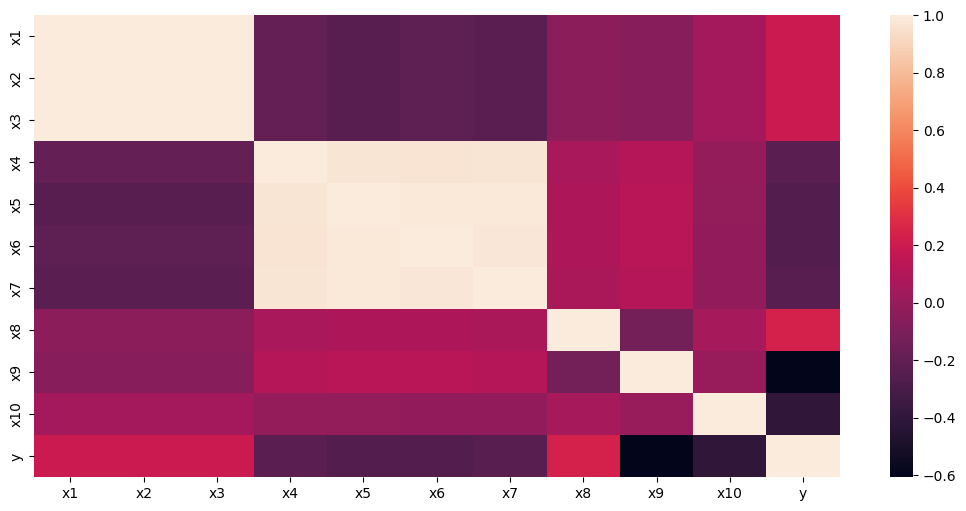

In [107]:
sns.heatmap(data.corr());

Do the predictors fall naturally into groups based on the correlation values?

We can see that higly correlated predictors fall into dark red groups based on correlation values close to 1. Other correlation values also form differently coloured groups.

**If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose?**

We may choose one predictor from the x1,x2,x3 list - let's pick x1.

Similarly, let's pick x6 out of x4,x5,x6,x7.

The other predictors are not strongly correlated, so we pick them all, i.e. x8,x9,x10.

Thus, we have picked 5 predictors x1, x6, x8, x9, x10 for our regression model.

**Note: Need to review interpreting heat maps before applying knowledge to your application**. They're pretty simple, but I remember them being very easy to mess up as well.

# Model Selection Criteria: Bayesian Information Criterion (BIC)

Generally BIC = -2 x Log-likehood + 2 x log(K)

For least-squares regression specifically,

$$\text{BIC} = n \log\left(\frac{\text{RSS}}{n}\right) + \log(n) * K$$

where,

RSS = Residual Sum of Squares

n = the number of obervations

K = the number of features in our model

## Selecting minimal subset of predictors

Let's apply the exhaustive search variable selection methods to choose a minimal subset of predictors that yield high prediction accuracy. We will use the BIC to choose the subset size.

In [113]:
x = data.iloc[:,:-1] # Exclude last column
y = data.iloc[:,-1] # Only the last column... gotta brush up those slicing skills son...

x.shape, y.shape

((100, 10), (100,))

In [116]:
def find_best_subset_of_size(x, y, num_predictors):
    predictors = x.columns
    
    best_r_squared = -np.inf
    best_model_data = None

    # Enumerate subsets of the given size
    subsets_of_size_k = itertools.combinations(predictors, num_predictors)

    # Inner loop: iterate through subsets_k
    for subset in subsets_of_size_k:

        # Fit regression model using ‘subset’ and calculate R^2 
        # Keep track of subset with highest R^2

        features = list(subset)
        x_subset = sm.add_constant(x[features])

        model = sm.OLS(y, x_subset).fit()
        r_squared = model.rsquared

        # Check if we get a higher R^2 value than than current max R^2.
        # If so, update our best subset 
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_model_data = {
                'r_squared': r_squared,
                'subset': features,
                'model': model
            }
    return best_model_data

In [117]:
find_best_subset_of_size(x, y, 8)

{'r_squared': np.float64(0.6445570800123954),
 'subset': ['x1', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'],
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x30afa2c30>}

In [118]:
def exhaustive_search_selection(x, y):
    """Exhaustively search predictor combinations

    Parameters:
    -----------
    x : DataFrame of predictors/features
    y : response varible 
    
    
    Returns:
    -----------
    
    Dataframe of model comparisons and OLS Model with 
    lowest BIC for subset with highest R^2
    
    """
    
    predictors = x.columns
    
    stats = []
    models = dict()
    
    # Outer loop: iterate over sizes 1, 2 .... d
    for k in range(1, len(predictors)):
        
        best_size_k_model = find_best_subset_of_size(
            x, y, num_predictors=k)
        best_subset = best_size_k_model['subset']
        best_model = best_size_k_model['model']
        
        stats.append({
            'k': k,
            'formula': "y ~ {}".format(' + '.join(best_subset)),
            'bic': best_model.bic,
            'r_squared': best_model.rsquared
        })
        models[k] = best_model
        
    return pd.DataFrame(stats), models

In [137]:
stats, models = exhaustive_search_selection(x, y)
stats.sort_values(by="bic")

,k,formula,bic,r_squared
4,5,y ~ x1 + x6 + x8 + x9 + x10,-72.366019,0.632807
3,4,y ~ x6 + x8 + x9 + x10,-71.007523,0.610243
5,6,y ~ x1 + x4 + x6 + x8 + x9 + x10,-70.354782,0.642209
6,7,y ~ x1 + x4 + x6 + x7 + x8 + x9 + x10,-66.158687,0.643670
2,3,y ~ x6 + x9 + x10,-65.728760,0.569751
7,8,y ~ x1 + x4 + x5 + x6 + x7 + x8 + x9 + x10,-61.802744,0.644557
8,9,y ~ x1 + x2 + x4 + x5 + x6 + x7 + x8 + x9 + x10,-61.802744,0.644557
1,2,y ~ x9 + x10,-61.732380,0.531105
0,1,y ~ x9,-36.720144,0.369475


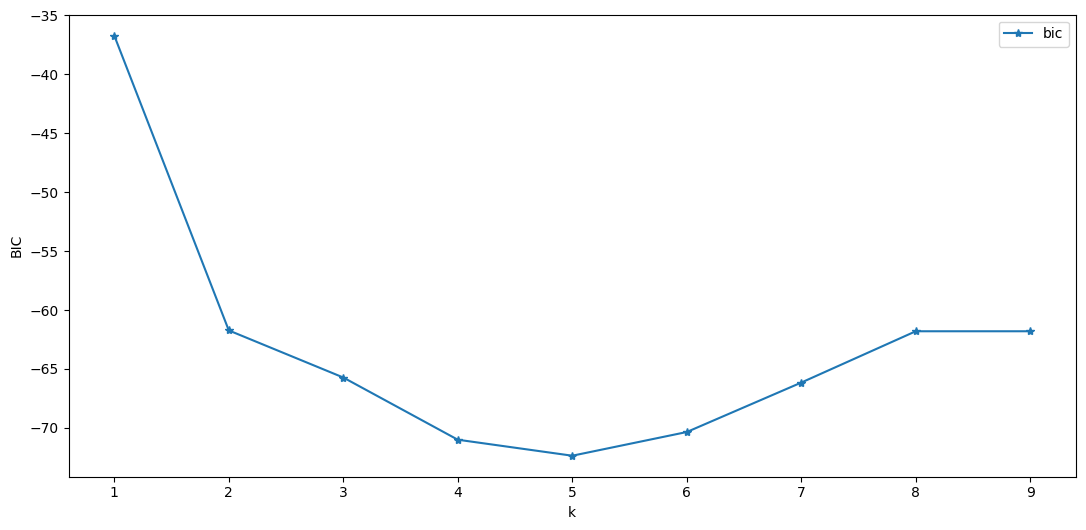

In [124]:
stats.plot(x="k", y="bic", marker="*")
plt.ylabel("BIC");

In [123]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   k          9 non-null      int64  
 1   formula    9 non-null      object 
 2   bic        9 non-null      float64
 3   r_squared  9 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 420.0+ bytes


In [138]:
best_stat = stats.iloc[stats.bic.idxmin()]
best_stat

k                                      5
formula      y ~ x1 + x6 + x8 + x9 + x10
bic                           -72.366019
r_squared                       0.632807
Name: 4, dtype: object

In [139]:
best_k = best_stat["k"]
best_bic = best_stat["bic"]
best_formula = best_stat["formula"]
best_r2 = best_stat["r_squared"]

In [140]:
print("The best overall model is `{formula}` with bic={bic:.2f} and R^2={r_squared:.3f}".format(
    formula=best_formula, bic=best_bic, r_squared=best_r2))

The best overall model is `y ~ x1 + x6 + x8 + x9 + x10` with bic=-72.37 and R^2=0.633


In [142]:
print(models[best_k].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     32.40
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           4.59e-19
Time:                        16:38:00   Log-Likelihood:                 49.999
No. Observations:                 100   AIC:                            -88.00
Df Residuals:                      94   BIC:                            -72.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.475e-17      0.015   9.74e-16      1.0

What's more, the chosen subsets match the ones picked using the correlation matric.